# 1. создание датасета
1.1 загружаем данные о двойных звездах из различных астрономических каталогов и объединяем их в один датасет.

1.2 обрабатываем координаты, преобразуя их в единый формат и удаляя записи с отсутствующими координатами.

In [6]:
import pandas as pd
import numpy as np
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Angle
import time


Vizier.ROW_LIMIT = 10000

def convert_coordinates(ra_str, dec_str):
    try:
        if isinstance(ra_str, (int, float)) and isinstance(dec_str, (int, float)):
            return ra_str, dec_str
        
        if isinstance(ra_str, str) and isinstance(dec_str, str):
            try:
                ra_angle = Angle(ra_str, unit=u.hourangle)
                dec_angle = Angle(dec_str, unit=u.deg)
                return ra_angle.deg, dec_angle.deg
            except:
                try:
                    ra_angle = Angle(ra_str, unit=u.deg)
                    dec_angle = Angle(dec_str, unit=u.deg)
                    return ra_angle.deg, dec_angle.deg
                except:
                    pass
        
        return float(ra_str), float(dec_str)
    except Exception as e:
        print(f"Ошибка конвертации координат RA={ra_str}, DEC={dec_str}: {e}")
        return None, None

def get_extended_binary_stars():
    catalogs_data = []
    
    print("Загрузка данных из каталогов...")
    
    print("1. WDS каталог...")
    try:
        wds_catalogs = Vizier.get_catalogs('B/wds/wds')
        for catalog in wds_catalogs:
            wds_df = catalog.to_pandas()
            wds_df['binary_type'] = 'Visual Binary'
            if len(wds_df) > 0:
                catalogs_data.append(wds_df.head(600))
        print(f"   Загружено визуально-двойных: {len(wds_df.head(600))}")
    except Exception as e:
        print(f"   Ошибка: {e}")
    
    print("2. SB9 каталог...")
    try:
        sb9_catalogs = Vizier.get_catalogs('B/sb9')
        for catalog in sb9_catalogs:
            sb9_df = catalog.to_pandas()
            sb9_df['binary_type'] = 'Spectroscopic Binary'
            if len(sb9_df) > 0:
                catalogs_data.append(sb9_df.head(500))
        print(f"   Загружено спектрально-двойных: {len(sb9_df.head(500))}")
    except Exception as e:
        print(f"   Ошибка: {e}")
    
    print("3. Kepler каталог...")
    try:
        kepler_catalogs = Vizier.get_catalogs('V/133')
        for catalog in kepler_catalogs:
            kepler_df = catalog.to_pandas()
            kepler_df['binary_type'] = 'Kepler Eclipsing Binary'
            if len(kepler_df) > 0:
                catalogs_data.append(kepler_df.head(400))
        print(f"   Загружено затменно-двойных: {len(kepler_df.head(400))}")
    except Exception as e:
        print(f"   Ошибка: {e}")
    
    print("4. Hipparcos каталог...")
    try:
        hip_catalogs = Vizier.get_catalogs('I/239/hip_dm')
        for catalog in hip_catalogs:
            hip_df = catalog.to_pandas()
            hip_df['binary_type'] = 'Hipparcos Astrometric Binary'
            if len(hip_df) > 0:
                catalogs_data.append(hip_df.head(300))
        print(f"   Загружено астрометрических двойных: {len(hip_df.head(300))}")
    except Exception as e:
        print(f"   Ошибка: {e}")
    
    print("5. ORB6 каталог...")
    try:
        orb6_catalogs = Vizier.get_catalogs('B/wds/orb6')
        for catalog in orb6_catalogs:
            orb6_df = catalog.to_pandas()
            orb6_df['binary_type'] = 'Binary with Known Orbit'
            if len(orb6_df) > 0:
                catalogs_data.append(orb6_df.head(200))
        print(f"   Загружено двойных с орбитами: {len(orb6_df.head(200))}")
    except Exception as e:
        print(f"   Ошибка: {e}")
    
    if catalogs_data:
        combined_df = pd.concat(catalogs_data, ignore_index=True, sort=False)
        print(f"Всего загружено: {len(combined_df)} звезд")
        
        ra_list, dec_list = [], []
        
        for idx, row in combined_df.iterrows():
            ra_str, dec_str = None, None
            
            ra_columns = ['RAJ2000', 'RA_ICRS', 'RA', '_RA', 'RAdeg', 'RA_deg', '_RAJ2000']
            dec_columns = ['DEJ2000', 'DE_ICRS', 'DEC', 'DE', '_DE', 'DEdeg', 'DE_deg', '_DEJ2000']
            
            for ra_col in ra_columns:
                if ra_col in row.index and pd.notna(row[ra_col]):
                    ra_str = row[ra_col]
                    break
            
            for dec_col in dec_columns:
                if dec_col in row.index and pd.notna(row[dec_col]):
                    dec_str = row[dec_col]
                    break
            
            if ra_str is not None and dec_str is not None:
                ra_deg, dec_deg = convert_coordinates(ra_str, dec_str)
                ra_list.append(ra_deg)
                dec_list.append(dec_deg)
            else:
                ra_list.append(None)
                dec_list.append(None)
        
        combined_df['ra_deg'] = ra_list
        combined_df['dec_deg'] = dec_list
        
        before_filter = len(combined_df)
        combined_df = combined_df.dropna(subset=['ra_deg', 'dec_deg'])
        after_filter = len(combined_df)
        print(f"Удалено записей без координат: {before_filter - after_filter}")
        
        return combined_df
    else:
        print("Не удалось загрузить данные")
        return pd.DataFrame()

def enhanced_simbad_info(df, batch_size=30):
    print("Добавление информации из SIMBAD...")
    
    simbad = Simbad()
    simbad.add_votable_fields('otype', 'sp_type', 'plx', 'pmra', 'pmdec', 'flux(V)', 'flux(B)', 'ids')
    simbad.TIMEOUT = 300
    
    otypes = []
    spectral_types = []
    parallaxes = []
    pmras = []
    pmdecs = []
    v_mags = []
    b_mags = []
    simbad_ids = []
    
    total = len(df)
    
    for i in range(0, total, batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_otypes = []
        batch_spectral_types = []
        batch_parallaxes = []
        batch_pmras = []
        batch_pmdecs = []
        batch_v_mags = []
        batch_b_mags = []
        batch_simbad_ids = []
        
        for idx, row in batch_df.iterrows():
            try:
                if pd.notna(row['ra_deg']) and pd.notna(row['dec_deg']):
                    coord = SkyCoord(ra=row['ra_deg']*u.degree, dec=row['dec_deg']*u.degree, frame='icrs')
                    
                    result = simbad.query_region(coord, radius=5*u.arcsec)
                    
                    if not result or len(result) == 0:
                        result = simbad.query_region(coord, radius=10*u.arcsec)
                    
                    if not result or len(result) == 0:
                        result = simbad.query_region(coord, radius=30*u.arcsec)
                    
                    if result and len(result) > 0:
                        otype = 'Unknown'
                        if 'OTYPE' in result.colnames and pd.notna(result['OTYPE'][0]):
                            otype = result['OTYPE'][0]
                        elif 'MAIN_ID' in result.colnames:
                            main_id = result['MAIN_ID'][0]
                            if any(indicator in main_id for indicator in ['BIN', 'SB', 'EB', 'V*', '**']):
                                otype = 'Binary'
                        
                        sp_type = result['SP_TYPE'][0] if 'SP_TYPE' in result.colnames and pd.notna(result['SP_TYPE'][0]) else 'Unknown'
                        plx = result['PLX_VALUE'][0] if 'PLX_VALUE' in result.colnames and pd.notna(result['PLX_VALUE'][0]) else None
                        pmra_val = result['PMRA'][0] if 'PMRA' in result.colnames and pd.notna(result['PMRA'][0]) else None
                        pmdec_val = result['PMDEC'][0] if 'PMDEC' in result.colnames and pd.notna(result['PMDEC'][0]) else None
                        v_mag = result['FLUX_V'][0] if 'FLUX_V' in result.colnames and pd.notna(result['FLUX_V'][0]) else None
                        b_mag = result['FLUX_B'][0] if 'FLUX_B' in result.colnames and pd.notna(result['FLUX_B'][0]) else None
                        simbad_id = result['MAIN_ID'][0] if 'MAIN_ID' in result.colnames and pd.notna(result['MAIN_ID'][0]) else ''
                        
                        batch_otypes.append(otype)
                        batch_spectral_types.append(sp_type)
                        batch_parallaxes.append(plx)
                        batch_pmras.append(pmra_val)
                        batch_pmdecs.append(pmdec_val)
                        batch_v_mags.append(v_mag)
                        batch_b_mags.append(b_mag)
                        batch_simbad_ids.append(simbad_id)
                    else:
                        alt_otype = determine_type_from_context(row)
                        batch_otypes.append(alt_otype)
                        batch_spectral_types.append('Unknown')
                        batch_parallaxes.append(None)
                        batch_pmras.append(None)
                        batch_pmdecs.append(None)
                        batch_v_mags.append(None)
                        batch_b_mags.append(None)
                        batch_simbad_ids.append('')
                else:
                    batch_otypes.append('No coordinates')
                    batch_spectral_types.append('Unknown')
                    batch_parallaxes.append(None)
                    batch_pmras.append(None)
                    batch_pmdecs.append(None)
                    batch_v_mags.append(None)
                    batch_b_mags.append(None)
                    batch_simbad_ids.append('')
                    
            except Exception as e:
                print(f"Ошибка для объекта {idx}: {e}")
                batch_otypes.append('Error')
                batch_spectral_types.append('Unknown')
                batch_parallaxes.append(None)
                batch_pmras.append(None)
                batch_pmdecs.append(None)
                batch_v_mags.append(None)
                batch_b_mags.append(None)
                batch_simbad_ids.append('')
        
        otypes.extend(batch_otypes)
        spectral_types.extend(batch_spectral_types)
        parallaxes.extend(batch_parallaxes)
        pmras.extend(batch_pmras)
        pmdecs.extend(batch_pmdecs)
        v_mags.extend(batch_v_mags)
        b_mags.extend(batch_b_mags)
        simbad_ids.extend(batch_simbad_ids)
        
        processed = min(i + batch_size, total)
        successful = len([x for x in batch_otypes if x not in ['Unknown', 'Not found', 'Error', 'No coordinates']])
        
        print(f"Обработано {processed}/{total} звезд")
        
        time.sleep(2)
    
    df['simbad_otype'] = otypes
    df['simbad_sp_type'] = spectral_types
    df['parallax'] = parallaxes
    df['pmra'] = pmras
    df['pmdec'] = pmdecs
    df['V_mag'] = v_mags
    df['B_mag'] = b_mags
    df['simbad_id'] = simbad_ids
    
    return df

def determine_type_from_context(row):
    binary_type = row.get('binary_type', '')
    
    if 'Eclipsing' in binary_type or 'Kepler' in binary_type:
        return 'Eclipsing binary candidate'
    elif 'Spectroscopic' in binary_type:
        return 'Spectroscopic binary candidate'
    elif 'Visual' in binary_type:
        return 'Visual binary candidate'
    elif 'Astrometric' in binary_type or 'Hipparcos' in binary_type:
        return 'Astrometric binary candidate'
    elif 'Orbit' in binary_type:
        return 'Binary with known orbit'
    else:
        return 'Star (binary candidate)'

def enhanced_binary_classification(df):
    print("Классификация двойных систем...")
    
    enhanced_types = []
    binary_categories = []
    
    for idx, row in df.iterrows():
        current_type = row['binary_type']
        simbad_otype = str(row.get('simbad_otype', ''))
        
        if 'Kepler' in current_type or 'Eclipsing' in current_type:
            main_category = 'Eclipsing Binary'
            source = 'Catalog'
        elif 'Spectroscopic' in current_type:
            main_category = 'Spectroscopic Binary'
            source = 'Catalog'
        elif 'Visual' in current_type:
            main_category = 'Visual Binary'
            source = 'Catalog'
        elif 'Astrometric' in current_type or 'Hipparcos' in current_type:
            main_category = 'Astrometric Binary'
            source = 'Catalog'
        elif 'Orbit' in current_type:
            main_category = 'Binary with Known Orbit'
            source = 'Catalog'
        elif 'EB*' in simbad_otype or 'Eclipsing' in simbad_otype:
            main_category = 'Eclipsing Binary'
            source = 'SIMBAD'
        elif 'SB*' in simbad_otype or 'Spectroscopic' in simbad_otype:
            main_category = 'Spectroscopic Binary'
            source = 'SIMBAD'
        elif 'B*' in simbad_otype:
            main_category = 'Confirmed Binary'
            source = 'SIMBAD'
        else:
            main_category = current_type
            source = 'Original Catalog'
        
        enhanced_type = f"{main_category}"
        enhanced_types.append(enhanced_type)
        binary_categories.append(main_category)
    
    df['enhanced_binary_type'] = enhanced_types
    df['binary_category'] = binary_categories
    df['is_astrometric'] = df['binary_category'] == 'Astrometric Binary'
    
    return df

def add_physical_parameters(df):
    print("Добавление физических параметров...")
    
    distances = []
    for plx in df['parallax']:
        if plx is not None and plx > 0:
            distance = 1000 / plx
            distances.append(distance)
        else:
            distances.append(None)
    
    df['distance_pc'] = distances
    
    abs_mags = []
    for idx, row in df.iterrows():
        if (row['V_mag'] is not None and row['distance_pc'] is not None and 
            row['distance_pc'] > 0):
            abs_mag = row['V_mag'] - 5 * np.log10(row['distance_pc'] / 10)
            abs_mags.append(abs_mag)
        else:
            abs_mags.append(None)
    
    df['abs_mag_V'] = abs_mags
    
    bv_colors = []
    for idx, row in df.iterrows():
        if row['B_mag'] is not None and row['V_mag'] is not None:
            bv = row['B_mag'] - row['V_mag']
            bv_colors.append(bv)
        else:
            bv_colors.append(None)
    
    df['B_V_color'] = bv_colors
    
    return df

print("Создание датасета двойных звезд...")

print("1. Загрузка данных из каталогов...")
binary_dataset = get_extended_binary_stars()

if len(binary_dataset) > 0:
    print(f"Первоначальный датасет: {len(binary_dataset)} звезд")
    
    print("2. Обогащение данными из SIMBAD...")
    binary_dataset = enhanced_simbad_info(binary_dataset)
    
    print("3. Классификация...")
    binary_dataset = enhanced_binary_classification(binary_dataset)
    
    print("4. Добавление физических параметров...")
    binary_dataset = add_physical_parameters(binary_dataset)
    
    print("5. Очистка датасета...")
    
    binary_dataset = binary_dataset.drop_duplicates(subset=['ra_deg', 'dec_deg'], keep='first')
    binary_dataset['ra_deg'] = binary_dataset['ra_deg'].fillna(0)
    binary_dataset['dec_deg'] = binary_dataset['dec_deg'].fillna(0)
    
    essential_columns = ['binary_type', 'enhanced_binary_type', 'binary_category', 'is_astrometric',
                        'ra_deg', 'dec_deg', 'simbad_otype', 'simbad_sp_type', 'simbad_id',
                        'parallax', 'distance_pc', 'pmra', 'pmdec', 'V_mag', 'B_mag',
                        'abs_mag_V', 'B_V_color']
    
    additional_columns = []
    for col in binary_dataset.columns:
        if col not in essential_columns:
            if any(x in col.lower() for x in ['mag', 'period', 'sep', 'distance', 'mass']):
                additional_columns.append(col)
    
    final_columns = essential_columns + additional_columns
    final_dataset = binary_dataset[final_columns].copy()
    
    output_file = "binary_stars_catalog_no_gaia.csv"
    final_dataset.to_csv(output_file, index=False, encoding='utf-8')
    
    print("Статистика датасета:")
    print(f"Общее количество систем: {len(final_dataset)}")
    
    print("Распределение по категориям:")
    category_counts = final_dataset['binary_category'].value_counts()
    for typ, count in category_counts.items():
        percentage = (count / len(final_dataset)) * 100
        print(f"  {typ}: {count} ({percentage:.1f}%)")
    
    print(f"Астрометрические двойные: {final_dataset['is_astrometric'].sum()}")
    print(f"Файл сохранен: {output_file}")
    
    display_columns = ['ra_deg', 'dec_deg', 'binary_category', 'enhanced_binary_type', 'simbad_otype']
    print("Первые 10 строк:")
    print(final_dataset.head(10)[display_columns].to_string())
    
else:
    print("Не удалось загрузить данные")

print("Завершено")

Создание датасета двойных звезд...
1. Загрузка данных из каталогов...
Загрузка данных из каталогов...
1. WDS каталог...
   Загружено визуально-двойных: 600
2. SB9 каталог...
   Загружено спектрально-двойных: 500
3. Kepler каталог...
   Загружено затменно-двойных: 400
4. Hipparcos каталог...
   Ошибка: local variable 'hip_df' referenced before assignment
5. ORB6 каталог...
   Ошибка: local variable 'orb6_df' referenced before assignment
Всего загружено: 2500 звезд
Удалено записей без координат: 1000
Первоначальный датасет: 1500 звезд
2. Обогащение данными из SIMBAD...
Добавление информации из SIMBAD...


C:\Users\rosen\AppData\Local\Temp\ipykernel_1300\2469153012.py:147: DeprecationWarning: The notation 'flux(V)' is deprecated since 0.4.8 in favor of 'V'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields('otype', 'sp_type', 'plx', 'pmra', 'pmdec', 'flux(V)', 'flux(B)', 'ids')
C:\Users\rosen\AppData\Local\Temp\ipykernel_1300\2469153012.py:147: DeprecationWarning: The notation 'flux(B)' is deprecated since 0.4.8 in favor of 'B'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields('otype', 'sp_type', 'plx', 'pmra', 'pmdec', 'flux(V)', 'flux(B)', 'ids')
C:\Users\rosen\AppData\Local\Temp\ipykernel_1300\2

Обработано 30/1500 звезд
Обработано 60/1500 звезд
Обработано 90/1500 звезд
Обработано 120/1500 звезд
Обработано 150/1500 звезд
Обработано 180/1500 звезд
Обработано 210/1500 звезд
Обработано 240/1500 звезд
Обработано 270/1500 звезд
Обработано 300/1500 звезд
Обработано 330/1500 звезд
Обработано 360/1500 звезд
Обработано 390/1500 звезд
Обработано 420/1500 звезд
Обработано 450/1500 звезд
Обработано 480/1500 звезд
Обработано 510/1500 звезд
Обработано 540/1500 звезд
Обработано 570/1500 звезд
Обработано 600/1500 звезд
Обработано 630/1500 звезд
Обработано 660/1500 звезд
Обработано 690/1500 звезд
Обработано 720/1500 звезд
Обработано 750/1500 звезд
Обработано 780/1500 звезд
Обработано 810/1500 звезд
Обработано 840/1500 звезд
Обработано 870/1500 звезд
Обработано 900/1500 звезд
Обработано 930/1500 звезд
Обработано 960/1500 звезд
Обработано 990/1500 звезд
Обработано 1020/1500 звезд
Обработано 1050/1500 звезд
Обработано 1080/1500 звезд
Обработано 1110/1500 звезд
Обработано 1140/1500 звезд
Обработано

# 2. анализ двойных звездных систем  
2.1 загружаем и строим графики изменения яркости во времени с помощью данных телескопа TESS.

2.2 показ кривых блеска для разных типов двойных систем, изменение яркости в зависимости от орбитального периода.

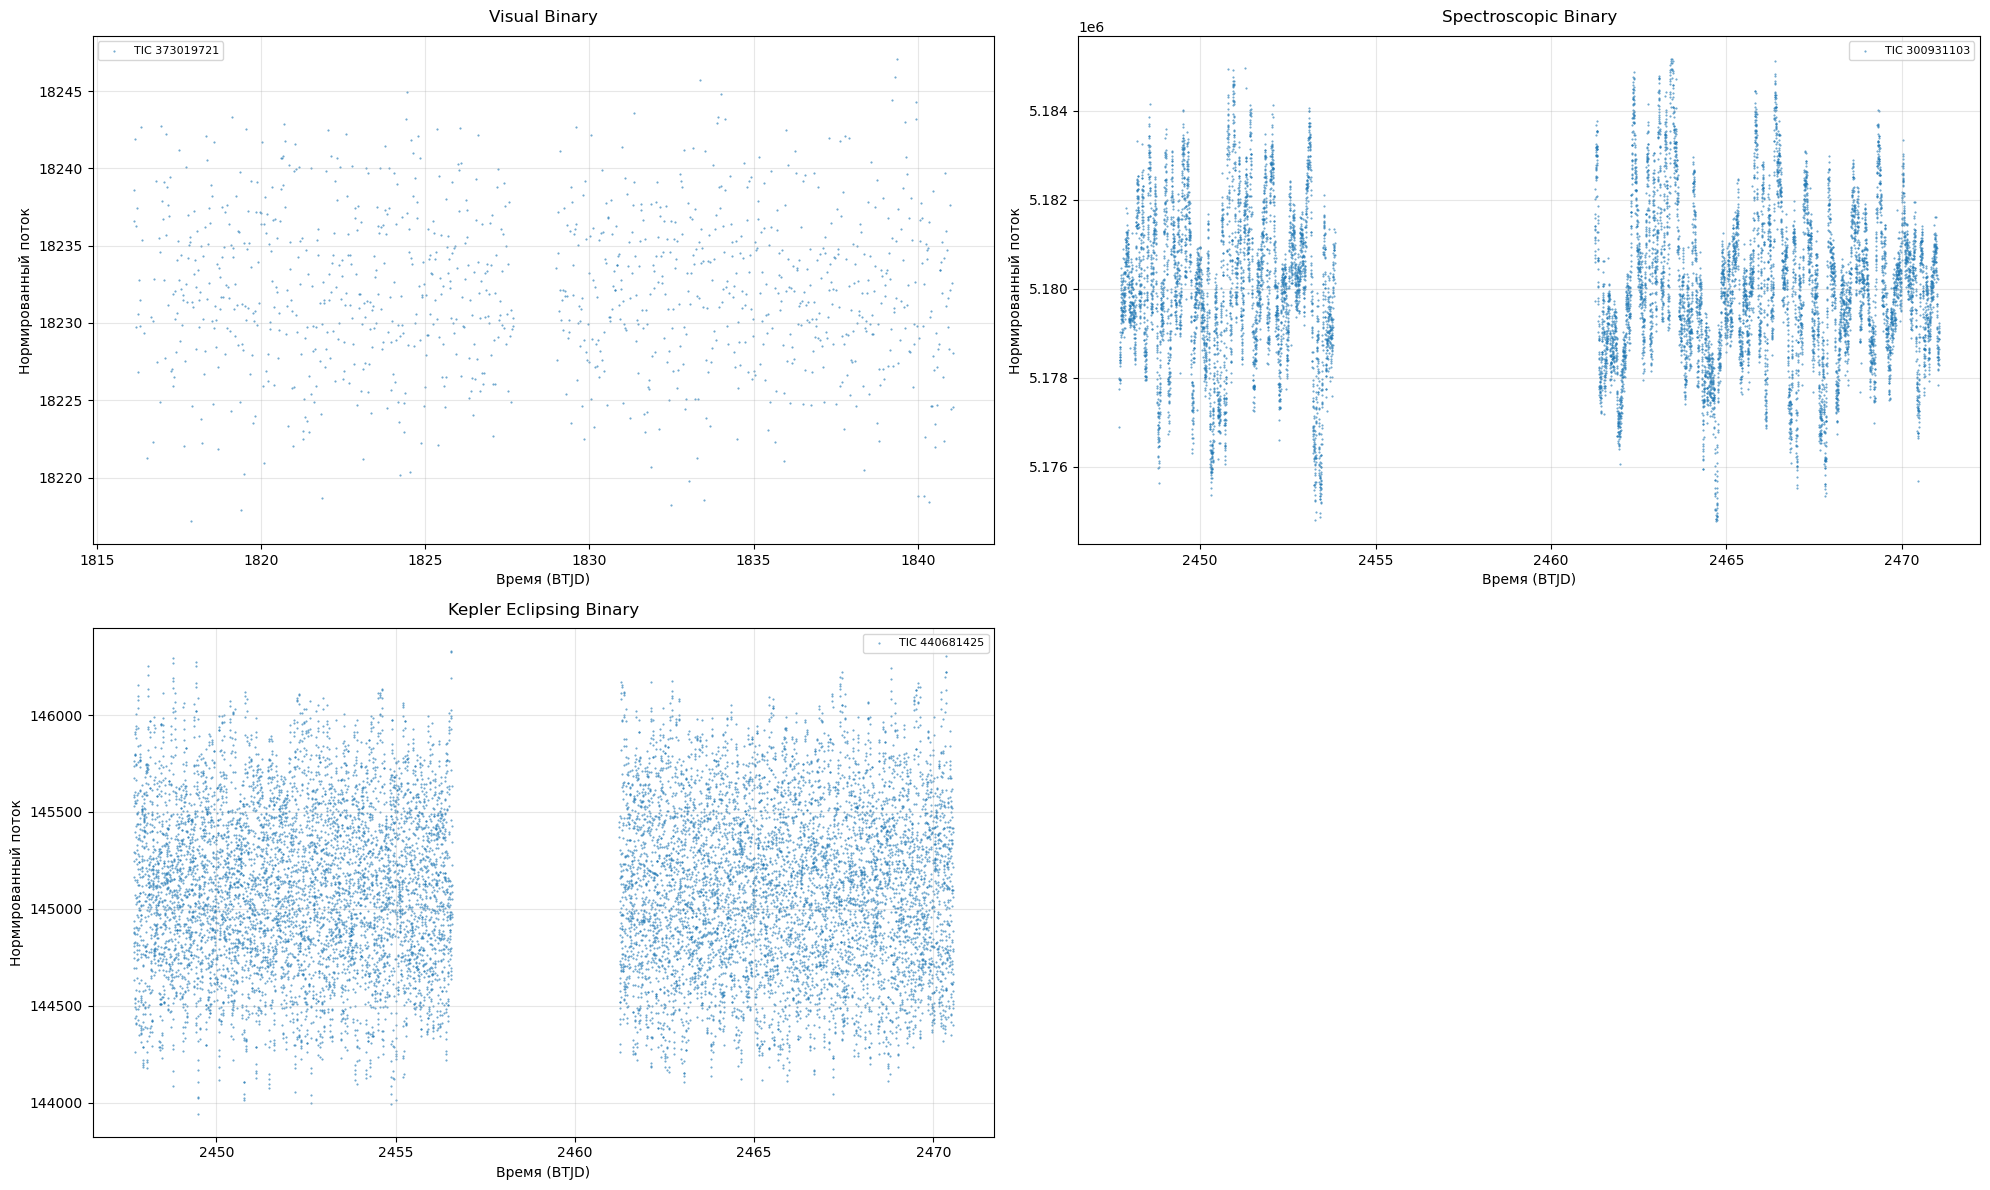

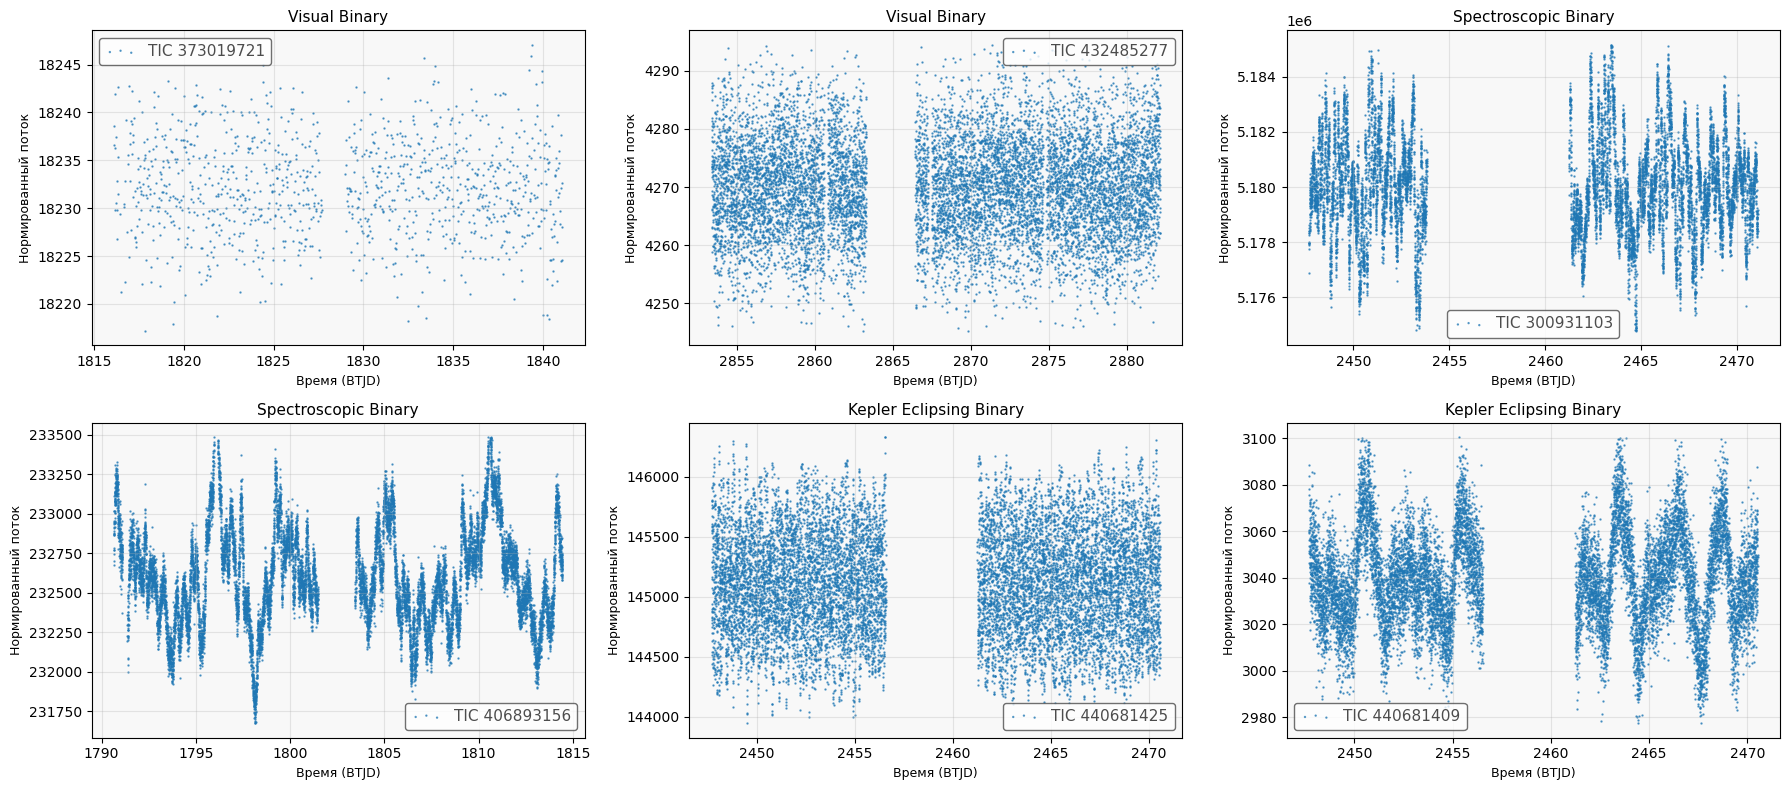

Не найдено звезд с информацией о периоде


In [8]:
import matplotlib.pyplot as plt
import lightkurve as lk


df = binary_dataset

def download_tess_lightcurve(tic_id, ra=None, dec=None):
    try:
        search_queries = []
        
        if pd.notna(tic_id) and tic_id != '':
            search_queries.extend([f"TIC {tic_id}", f"TIC{tic_id}", str(tic_id)])
        
        if ra is not None and dec is not None and pd.notna(ra) and pd.notna(dec):
            coord = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs')
            search_result = lk.search_lightcurve(coord, radius=0.02*u.degree, mission='TESS')
            if len(search_result) > 0:
                lc_data = search_result[0].download()
                return lc_data
        
        for query in search_queries:
            try:
                search_result = lk.search_lightcurve(query, mission='TESS')
                if len(search_result) > 0:
                    lc_data = search_result[0].download()
                    return lc_data
            except:
                continue
        
        return None
        
    except Exception as e:
        print(f"Ошибка при загрузке TIC {tic_id}: {e}")
        return None

def plot_light_curves_by_type(df, stars_per_type=3):
    binary_types = df['binary_type'].unique()
    
    n_types = len(binary_types)
    n_cols = 2
    n_rows = (n_types + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    success_count = 0
    
    for idx, binary_type in enumerate(binary_types):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        type_stars = df[df['binary_type'] == binary_type].head(stars_per_type)
        
        for star_idx, star_row in type_stars.iterrows():
            try:
                tic_id = star_row.get('tic_id')
                ra = star_row.get('ra_deg')
                dec = star_row.get('dec_deg')
                
                lc = download_tess_lightcurve(tic_id, ra, dec)
                
                if lc is not None:
                    lc_clean = lc.remove_nans().remove_outliers(sigma=3)
                    
                    if len(lc_clean) > 10:
                        lc_clean.scatter(ax=ax, s=1, alpha=0.7, 
                                       label=f'TIC {getattr(lc, "targetid", "Unknown")}')
                        
                        success_count += 1
                        break
                    
                time.sleep(0.5)
                
            except Exception as e:
                continue
        
        ax.set_title(f'{binary_type}', fontsize=12, pad=10)
        ax.set_ylabel('Нормированный поток', fontsize=10)
        ax.set_xlabel('Время (BTJD)', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        if len(ax.lines) == 0 and len(ax.collections) == 0:
            ax.text(0.5, 0.5, 'Данные не найдены', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_facecolor('#f8f8f8')
    
    for idx in range(len(binary_types), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_detailed_light_curves(df, num_stars=12):
    selected_stars = []
    for binary_type in df['binary_type'].unique():
        type_stars = df[df['binary_type'] == binary_type].head(2)
        selected_stars.append(type_stars)
    
    if selected_stars:
        selected_df = pd.concat(selected_stars, ignore_index=True)
    else:
        selected_df = df.head(num_stars)
    
    selected_df = selected_df.head(num_stars)
    
    n_cols = 3
    n_rows = (len(selected_df) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    success_count = 0
    
    for idx, (star_idx, star_row) in enumerate(selected_df.iterrows()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        try:
            tic_id = star_row.get('tic_id')
            ra = star_row.get('ra_deg')
            dec = star_row.get('dec_deg')
            binary_type = star_row.get('binary_type')
            
            lc = download_tess_lightcurve(tic_id, ra, dec)
            
            if lc is not None:
                lc_clean = lc.remove_nans().remove_outliers(sigma=3)
                
                if len(lc_clean) > 10:
                    lc_clean.scatter(ax=ax, s=2, alpha=0.7)
                    
                    star_info = f"{binary_type}"
                    if pd.notna(tic_id):
                        star_info += f"\nTIC {tic_id}"
                    
                    ax.set_title(star_info, fontsize=11)
                    ax.set_ylabel('Нормированный поток', fontsize=9)
                    ax.set_xlabel('Время (BTJD)', fontsize=9)
                    ax.grid(True, alpha=0.3)
                    
                    success_count += 1
                else:
                    ax.text(0.5, 0.5, 'Недостаточно данных', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f"{binary_type}\nTIC {tic_id}", fontsize=11)
            else:
                ax.text(0.5, 0.5, 'Данные не найдены', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{binary_type}\nTIC {tic_id}", fontsize=11)
            
            ax.set_facecolor('#f8f8f8')
            time.sleep(0.5)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Ошибка:\n{e}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=8)
            ax.set_facecolor('#f8f8f8')
    
    for idx in range(len(selected_df), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_phased_light_curves(df):
    stars_with_period = []
    for _, star_row in df.iterrows():
        period = star_row.get('Per')
        if pd.notna(period) and period > 0:
            stars_with_period.append(star_row)
    
    if not stars_with_period:
        print("Не найдено звезд с информацией о периоде")
        return
    
    stars_with_period = pd.DataFrame(stars_with_period).head(6)
    
    n_cols = 2
    n_rows = (len(stars_with_period) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    success_count = 0
    
    for idx, (star_idx, star_row) in enumerate(stars_with_period.iterrows()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        try:
            tic_id = star_row.get('tic_id')
            ra = star_row.get('ra_deg')
            dec = star_row.get('dec_deg')
            period = star_row.get('Per')
            binary_type = star_row.get('binary_type')
            
            lc = download_tess_lightcurve(tic_id, ra, dec)
            
            if lc is not None and period > 0:
                lc_clean = lc.remove_nans().remove_outliers(sigma=3)
                
                if len(lc_clean) > 10:
                    lc_folded = lc_clean.fold(period=period * u.day)
                    lc_folded.scatter(ax=ax, s=2, alpha=0.7)
                    
                    ax.set_title(f'{binary_type}\nP = {period:.3f} д\nTIC {tic_id}', fontsize=11)
                    ax.set_ylabel('Нормированный поток', fontsize=9)
                    ax.set_xlabel('Фаза', fontsize=9)
                    ax.grid(True, alpha=0.3)
                    
                    success_count += 1
                else:
                    ax.text(0.5, 0.5, 'Недостаточно данных', 
                           ha='center', va='center', transform=ax.transAxes)
            else:
                ax.text(0.5, 0.5, 'Нет данных или периода', 
                       ha='center', va='center', transform=ax.transAxes)
            
            ax.set_facecolor('#f8f8f8')
            time.sleep(0.5)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Ошибка\n{e}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=8)
    
    for idx in range(len(stars_with_period), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_light_curves_by_type(df, stars_per_type=3)
plot_detailed_light_curves(df, num_stars=12)
plot_phased_light_curves(df)

# 3. скачивание датасета
3.1 скачиваем и сохраняем кривые блеска двойных звезд из архива TESS, используя их идентификаторы или координаты. 

3.2 Для каждой звезды создаем CSV-файл с данными и PNG-график, а также формируем отчеты о результатах загрузки.

In [ ]:
import os
from pathlib import Path

# Загрузка датасета
df = binary_dataset

# Создаем папку для сохранения кривых блеска
lightcurve_dir = Path("binary_star")
lightcurve_dir.mkdir(exist_ok=True)

def download_and_save_tess_lightcurve(star_id, tic_id, ra=None, dec=None, binary_type="Unknown"):
    """Загружает и сохраняет кривую блеска TESS"""
    
    type_dir = lightcurve_dir / binary_type.replace(" ", "_")
    type_dir.mkdir(exist_ok=True)
    
    try:
        search_queries = []
        
        if pd.notna(tic_id) and tic_id != '':
            search_queries.extend([f"TIC {tic_id}", f"TIC{tic_id}", str(tic_id)])
        
        lc_data = None
        if ra is not None and dec is not None and pd.notna(ra) and pd.notna(dec):
            try:
                coord = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs')
                search_result = lk.search_lightcurve(coord, radius=0.02*u.degree, mission='TESS')
                if len(search_result) > 0:
                    lc_data = search_result[0].download()
            except:
                pass
        
        if lc_data is None:
            for query in search_queries:
                try:
                    search_result = lk.search_lightcurve(query, mission='TESS')
                    if len(search_result) > 0:
                        lc_data = search_result[0].download()
                        break
                except:
                    continue
        
        if lc_data is not None:
            lc_clean = lc_data.remove_nans().remove_outliers(sigma=3)
            
            if len(lc_clean) > 10:
                filename = f"star_{star_id}_tic_{tic_id if pd.notna(tic_id) else 'unknown'}.csv"
                filepath = type_dir / filename
                
                lc_df = pd.DataFrame({
                    'time': lc_clean.time.value,
                    'flux': lc_clean.flux.value,
                    'flux_err': lc_clean.flux_err.value if hasattr(lc_clean.flux_err, 'value') else np.zeros_like(lc_clean.flux.value)
                })
                
                lc_df.to_csv(filepath, index=False)
                
                plot_filename = f"star_{star_id}_tic_{tic_id if pd.notna(tic_id) else 'unknown'}.png"
                plot_filepath = type_dir / plot_filename
                
                plt.figure(figsize=(10, 6))
                plt.scatter(lc_clean.time.value, lc_clean.flux.value, s=1, alpha=0.7)
                plt.xlabel('Time (BTJD)')
                plt.ylabel('Normalized Flux')
                plt.title(f'Star {star_id} - {binary_type}\nTIC: {tic_id}')
                plt.grid(True, alpha=0.3)
                plt.savefig(plot_filepath, dpi=150, bbox_inches='tight')
                plt.close()
                
                return {
                    'success': True,
                    'filepath': str(filepath),
                    'plot_path': str(plot_filepath),
                    'data_points': len(lc_clean),
                    'targetid': getattr(lc_data, 'targetid', 'Unknown')
                }
            else:
                return {
                    'success': False,
                    'error': f'Недостаточно данных: {len(lc_clean)} точек',
                    'data_points': len(lc_clean)
                }
        else:
            return {
                'success': False,
                'error': 'Данные не найдены',
                'data_points': 0
            }
        
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'data_points': 0
        }

def download_all_lightcurves(df, max_stars=None, delay=1):
    """Загружает все кривые блеска для датасета"""
    
    results = []
    success_count = 0
    total_stars = len(df) if max_stars is None else min(max_stars, len(df))
    
    print(f"Начинаем загрузку кривых блеска для {total_stars} звезд...")
    
    for idx, (star_idx, star_row) in enumerate(df.iterrows()):
        if max_stars is not None and idx >= max_stars:
            break
            
        star_id = idx + 1
        tic_id = star_row.get('TIC')
        ra = star_row.get('ra_deg')
        dec = star_row.get('dec_deg')
        binary_type = star_row.get('binary_type', 'Unknown')
        wds_id = star_row.get('WDS', 'Unknown')
        
        print(f"Загрузка {idx+1}/{total_stars}: {binary_type} - WDS: {wds_id}")
        
        result = download_and_save_tess_lightcurve(star_id, tic_id, ra, dec, binary_type)
        
        result.update({
            'star_id': star_id,
            'wds_id': wds_id,
            'tic_id': tic_id,
            'binary_type': binary_type,
            'ra': ra,
            'dec': dec
        })
        
        results.append(result)
        
        if result['success']:
            success_count += 1
            print(f"Успешно: {result['data_points']} точек")
        else:
            print(f"Ошибка: {result['error']}")
        
        time.sleep(delay)
    
    return results, success_count

def create_download_report(results, output_file="download_report.csv"):
    """Создает отчет о загрузке кривых блеска"""
    
    report_data = []
    for result in results:
        report_data.append({
            'star_id': result['star_id'],
            'wds_id': result['wds_id'],
            'tic_id': result['tic_id'],
            'binary_type': result['binary_type'],
            'ra': result['ra'],
            'dec': result['dec'],
            'success': result['success'],
            'data_points': result['data_points'],
            'error': result.get('error', ''),
            'filepath': result.get('filepath', ''),
            'plot_path': result.get('plot_path', ''),
            'targetid': result.get('targetid', '')
        })
    
    report_df = pd.DataFrame(report_data)
    report_df.to_csv(lightcurve_dir / output_file, index=False)
    return report_df

def create_summary_statistics(results, df):
    """Создает сводную статистику по загрузке"""
    
    total_stars = len(results)
    successful_downloads = sum(1 for r in results if r['success'])
    failed_downloads = total_stars - successful_downloads
    
    type_stats = {}
    for result in results:
        binary_type = result['binary_type']
        if binary_type not in type_stats:
            type_stats[binary_type] = {'total': 0, 'success': 0}
        
        type_stats[binary_type]['total'] += 1
        if result['success']:
            type_stats[binary_type]['success'] += 1
    
    print(f"Всего обработано звезд: {total_stars}")
    print(f"Успешных загрузок: {successful_downloads} ({successful_downloads/total_stars*100:.1f}%)")
    print(f"Неудачных загрузок: {failed_downloads}")
    
    print("Статистика по типам систем:")
    for binary_type, stats in type_stats.items():
        success_rate = stats['success'] / stats['total'] * 100 if stats['total'] > 0 else 0
        print(f"  {binary_type}: {stats['success']}/{stats['total']} ({success_rate:.1f}%)")
    
    stats_data = []
    for binary_type, stats in type_stats.items():
        stats_data.append({
            'binary_type': binary_type,
            'total_stars': stats['total'],
            'successful_downloads': stats['success'],
            'success_rate': stats['success'] / stats['total'] * 100 if stats['total'] > 0 else 0
        })
    
    stats_df = pd.DataFrame(stats_data)
    stats_df.to_csv(lightcurve_dir / "download_statistics.csv", index=False)
    
    return stats_df

# Основной процесс загрузки
print("Загрузка кривых блеска двойных звезд")
print(f"Всего звезд в датасете: {len(df)}")
print("Распределение по типам:")
print(df['binary_type'].value_counts())

results, success_count = download_all_lightcurves(
    df, 
    max_stars=None,
    delay=1
)

print("Создание отчетов...")
report_df = create_download_report(results)
stats_df = create_summary_statistics(results, df)

readme_content = f"""
# Кривые блеска двойных звезд

Папка содержит кривые блеска TESS для двойных звезд.

Статистика:
- Всего звезд в датасете: {len(df)}
- Обработано звезд: {len(results)}
- Успешных загрузок: {success_count}
- Процент успеха: {success_count/len(results)*100:.1f}%

Данные загружены: {pd.Timestamp.now()}
"""

with open(lightcurve_dir / "README.md", "w", encoding="utf-8") as f:
    f.write(readme_content)

print("Загрузка завершена!")
print(f"Успешно загружено: {success_count} из {len(results)} кривых блеска")

successful_results = [r for r in results if r['success']]
if successful_results:
    print("Примеры успешных загрузок:")
    for i, result in enumerate(successful_results[:3]):
        print(f"  {result['binary_type']} - {result['data_points']} точек")

# 4. создание классификатора
4.1 тестируем нейросетевую модель для классификации типов двойных звезд по их кривым блеска. 

4.2 загружаем реальные данные, предобрабатываем их, делаем предсказания и оцениваем точность модели на тестовых выборках.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import warnings
import joblib
import json
from scipy import signal
import random
warnings.filterwarnings('ignore')

def load_and_preprocess_single_lightcurve(file_path):
    try:
        df = pd.read_csv(file_path)
        
        if len(df) < 30:
            return None, None
        
        if 'flux' in df.columns and 'time' in df.columns:
            df['flux'] = pd.to_numeric(df['flux'], errors='coerce')
            df['time'] = pd.to_numeric(df['time'], errors='coerce')
            df = df.dropna(subset=['flux', 'time'])
            
            flux = df['flux'].values.astype(np.float32)
            time = df['time'].values.astype(np.float32)
            
            processed_series = preprocess_for_prediction(flux, time)
            
        elif 'flux' in df.columns:
            df['flux'] = pd.to_numeric(df['flux'], errors='coerce')
            df = df.dropna(subset=['flux'])
            
            flux = df['flux'].values.astype(np.float32)
            processed_series = preprocess_for_prediction(flux)
        
        else:
            return None, None
            
        return processed_series, file_path
        
    except Exception as e:
        print(f"Ошибка при загрузке {file_path}: {e}")
        return None, None

def preprocess_for_prediction(flux, time=None):
    try:
        flux = flux.astype(np.float32)
        
        Q1 = np.percentile(flux, 25)
        Q3 = np.percentile(flux, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        mask = (flux >= lower_bound) & (flux <= upper_bound)
        flux_clean = flux[mask]
        
        if len(flux_clean) < 30:
            return None
            
        window_length = min(11, len(flux_clean) - 1)
        if window_length % 2 == 0:
            window_length = max(3, window_length - 1)
        
        polyorder = min(3, window_length - 1)
        
        flux_smooth = signal.savgol_filter(flux_clean, 
                                         window_length=window_length, 
                                         polyorder=polyorder)
        
        flux_norm = (flux_smooth - np.mean(flux_smooth)) / (np.std(flux_smooth) + 1e-8)
        
        target_length = 1000
        
        if len(flux_norm) < target_length:
            x_old = np.linspace(0, 1, len(flux_norm))
            x_new = np.linspace(0, 1, target_length)
            flux_interp = np.interp(x_new, x_old, flux_norm)
        else:
            start_idx = (len(flux_norm) - target_length) // 2
            flux_interp = flux_norm[start_idx:start_idx + target_length]
        
        return flux_interp.astype(np.float32)
        
    except Exception as e:
        print(f"Ошибка в предобработке: {e}")
        return None

def predict_lightcurve(model, lightcurve_data, label_encoder):
    """Предсказывает тип звезды по кривой блеска"""
    if lightcurve_data is None:
        return "Ошибка: некорректные данные", 0.0, None
    
    lightcurve_data = lightcurve_data.reshape(1, -1, 1)
    
    prediction = model.predict(lightcurve_data, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    all_probabilities = prediction[0]
    
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label, confidence, all_probabilities

def test_random_lightcurves(lightcurve_dir, model_path, num_samples=20):
    """Тестирует случайные кривые блеска из датасета"""
    
    model_dir = Path("binary_stars_classifier_improved")
    
    try:
        model = keras.models.load_model(str(model_dir / model_path))
        label_encoder = joblib.load(str(model_dir / "label_encoder.pkl"))
        print("Модель и encoder успешно загружены")
    except Exception as e:
        print(f"Ошибка загрузки модели: {e}")
        return
    
    all_files = []
    lightcurve_path = Path(lightcurve_dir)
    
    for binary_type_dir in lightcurve_path.iterdir():
        if binary_type_dir.is_dir():
            for csv_file in binary_type_dir.glob("*.csv"):
                all_files.append((csv_file, binary_type_dir.name))
    
    if not all_files:
        print("Не найдено файлов для тестирования")
        return
    
    print(f"Найдено {len(all_files)} файлов в датасете")
    
    test_files = random.sample(all_files, min(num_samples, len(all_files)))
    
    results = []
    
    print(f"Тестирование {len(test_files)} случайных кривых блеска...")
    
    for i, (file_path, true_class) in enumerate(test_files):
        print(f"Тест {i+1}/{len(test_files)}")
        print(f"Файл: {file_path.name}")
        print(f"Истинный класс: {true_class.replace('_', ' ')}")
        
        lightcurve_data, _ = load_and_preprocess_single_lightcurve(file_path)
        
        if lightcurve_data is not None:
            predicted_label, confidence, probabilities = predict_lightcurve(
                model, lightcurve_data, label_encoder
            )
            
            is_correct = (predicted_label == true_class.replace('_', ' '))
            status = "ПРАВИЛЬНО" if is_correct else "НЕПРАВИЛЬНО"
            
            print(f"Предсказание: {predicted_label}")
            print(f"Уверенность: {confidence:.4f}")
            print(f"Статус: {status}")
            
            results.append({
                'file': file_path.name,
                'true_class': true_class.replace('_', ' '),
                'predicted_class': predicted_label,
                'confidence': confidence,
                'correct': is_correct,
                'probabilities': probabilities
            })
            
            plt.figure(figsize=(12, 4))
            plt.plot(lightcurve_data, alpha=0.8, linewidth=1.5, color='blue')
            plt.title(f'Кривая блеска\nИстинный: {true_class.replace("_", " ")} | Предсказанный: {predicted_label}\nУверенность: {confidence:.4f} | {status}')
            plt.xlabel('Время')
            plt.ylabel('Нормированный поток')
            plt.grid(True, alpha=0.3)
            
            if is_correct:
                plt.gca().patch.set_edgecolor('green')
            else:
                plt.gca().patch.set_edgecolor('red')
            plt.gca().patch.set_linewidth(3)
            
            plt.tight_layout()
            plt.show()
            
        else:
            print("Не удалось загрузить или обработать данные")
            results.append({
                'file': file_path.name,
                'true_class': true_class.replace('_', ' '),
                'predicted_class': 'Ошибка обработки',
                'confidence': 0.0,
                'correct': False,
                'probabilities': None
            })
    
    print("СВОДКА РЕЗУЛЬТАТОВ ТЕСТИРОВАНИЯ")
    
    if results:
        correct_predictions = sum(1 for r in results if r['correct'])
        total_predictions = len([r for r in results if r['predicted_class'] != 'Ошибка обработки'])
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        print(f"Правильных предсказаний: {correct_predictions}/{total_predictions}")
        print(f"Точность: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        print("РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ:")
        class_stats = {}
        for result in results:
            true_class = result['true_class']
            if true_class not in class_stats:
                class_stats[true_class] = {'total': 0, 'correct': 0}
            class_stats[true_class]['total'] += 1
            if result['correct']:
                class_stats[true_class]['correct'] += 1
        
        for class_name, stats in class_stats.items():
            class_accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
            print(f"  {class_name}: {stats['correct']}/{stats['total']} ({class_accuracy:.4f})")
        
        print("МАТРИЦА ОШИБОК:")
        true_labels = [r['true_class'] for r in results if r['predicted_class'] != 'Ошибка обработки']
        pred_labels = [r['predicted_class'] for r in results if r['predicted_class'] != 'Ошибка обработки']
        
        if true_labels and pred_labels:
            cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=label_encoder.classes_, 
                       yticklabels=label_encoder.classes_)
            plt.title(f'Матрица ошибок тестирования\nОбщая точность: {accuracy:.4f}')
            plt.xlabel('Предсказанные')
            plt.ylabel('Истинные')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        
        results_df = pd.DataFrame(results)
        results_df.to_csv(str(model_dir / "test_results.csv"), index=False)
        print(f"Результаты сохранены в: {model_dir / 'test_results.csv'}")
        
        return accuracy, results_df
    
    return 0, None

def test_specific_classes(lightcurve_dir, model_path, samples_per_class=5):
    """Тестирует конкретные классы с балансировкой"""
    
    model_dir = Path("binary_stars_classifier_improved")
    
    try:
        model = keras.models.load_model(str(model_dir / model_path))
        label_encoder = joblib.load(str(model_dir / "label_encoder.pkl"))
        print("Модель и encoder успешно загружены")
    except Exception as e:
        print(f"Ошибка загрузки модели: {e}")
        return
    
    class_files = {}
    lightcurve_path = Path(lightcurve_dir)
    
    for binary_type_dir in lightcurve_path.iterdir():
        if binary_type_dir.is_dir():
            class_name = binary_type_dir.name.replace('_', ' ')
            class_files[class_name] = list(binary_type_dir.glob("*.csv"))
    
    print("ТЕСТИРОВАНИЕ ПО КЛАССАМ:")
    
    results = []
    
    for class_name, files in class_files.items():
        print(f"Класс: {class_name}")
        print(f"Доступно файлов: {len(files)}")
        
        test_files = random.sample(files, min(samples_per_class, len(files)))
        
        for i, file_path in enumerate(test_files):
            print(f"  Тест {i+1}/{len(test_files)}: {file_path.name}")
            
            lightcurve_data, _ = load_and_preprocess_single_lightcurve(file_path)
            
            if lightcurve_data is not None:
                predicted_label, confidence, probabilities = predict_lightcurve(
                    model, lightcurve_data, label_encoder
                )
                
                is_correct = (predicted_label == class_name)
                status = "ВЕРНО" if is_correct else "ОШИБКА"
                
                print(f"    {status} Предсказано: {predicted_label} (уверенность: {confidence:.4f})")
                
                results.append({
                    'file': file_path.name,
                    'true_class': class_name,
                    'predicted_class': predicted_label,
                    'confidence': confidence,
                    'correct': is_correct,
                    'probabilities': probabilities
                })
            else:
                print(f"    Ошибка обработки данных")
                results.append({
                    'file': file_path.name,
                    'true_class': class_name,
                    'predicted_class': 'Ошибка обработки',
                    'confidence': 0.0,
                    'correct': False,
                    'probabilities': None
                })
    
    if results:
        results_df = pd.DataFrame(results)
        
        print("ИТОГИ ТЕСТИРОВАНИЯ ПО КЛАССАМ")
        
        class_accuracy = results_df.groupby('true_class').agg({
            'correct': ['count', 'sum']
        }).round(4)
        
        class_accuracy['accuracy'] = class_accuracy[('correct', 'sum')] / class_accuracy[('correct', 'count')]
        
        print("ТОЧНОСТЬ ПО КЛАССАМ:")
        for class_name in class_accuracy.index:
            stats = class_accuracy.loc[class_name]
            accuracy = stats['accuracy']
            correct = int(stats[('correct', 'sum')])
            total = int(stats[('correct', 'count')])
            print(f"  {class_name}: {correct}/{total} ({accuracy:.4f})")
        
        total_correct = results_df['correct'].sum()
        total_tests = len(results_df[results_df['predicted_class'] != 'Ошибка обработки'])
        overall_accuracy = total_correct / total_tests if total_tests > 0 else 0
        
        print(f"ОБЩАЯ ТОЧНОСТЬ: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
        print(f"Правильных: {total_correct}/{total_tests}")
        
        results_df.to_csv(str(model_dir / "class_test_results.csv"), index=False)
        print(f"Результаты сохранены в: {model_dir / 'class_test_results.csv'}")
        
        return overall_accuracy, results_df
    
    return 0, None

if __name__ == "__main__":
    lightcurve_dir = "C:/Users/rosen/Desktop/allussi/binary_star"
    model_path = "best_model.h5"
    
    print("Запуск тестирования модели на реальных данных")
    
    print("Тест случайных кривых блеска")
    accuracy1, results1 = test_random_lightcurves(lightcurve_dir, model_path, num_samples=15)
    
    print("Сбалансированное тестирование по классам")
    accuracy2, results2 = test_specific_classes(lightcurve_dir, model_path, samples_per_class=3)
    
    print("Тестирование завершено")
    
    if accuracy1 > 0:
        print(f"Точность на случайных данных: {accuracy1:.4f}")
    if accuracy2 > 0:
        print(f"Точность по классам: {accuracy2:.4f}")